In [ ]:
# Start writing code here...

Epoch 1, Training Loss: 1.1129, Validation Loss: 0.0384, Validation Accuracy: 0.7611, Validation Precision: 0.7120, Validation Recall: 0.8718, Validation F1-Score: 0.7839
Epoch 2, Training Loss: 1.0824, Validation Loss: 0.0351, Validation Accuracy: 0.8025, Validation Precision: 0.8219, Validation Recall: 0.7692, Validation F1-Score: 0.7947
Epoch 3, Training Loss: 1.0557, Validation Loss: 0.0335, Validation Accuracy: 0.8025, Validation Precision: 0.8983, Validation Recall: 0.6795, Validation F1-Score: 0.7737
Epoch 4, Training Loss: 1.0337, Validation Loss: 0.0302, Validation Accuracy: 0.8981, Validation Precision: 0.8974, Validation Recall: 0.8974, Validation F1-Score: 0.8974
Epoch 5, Training Loss: 1.0146, Validation Loss: 0.0287, Validation Accuracy: 0.9045, Validation Precision: 0.8987, Validation Recall: 0.9103, Validation F1-Score: 0.9045
Epoch 6, Training Loss: 0.9982, Validation Loss: 0.0300, Validation Accuracy: 0.8439, Validation Precision: 0.7635, Validation Recall: 0.9936, Va

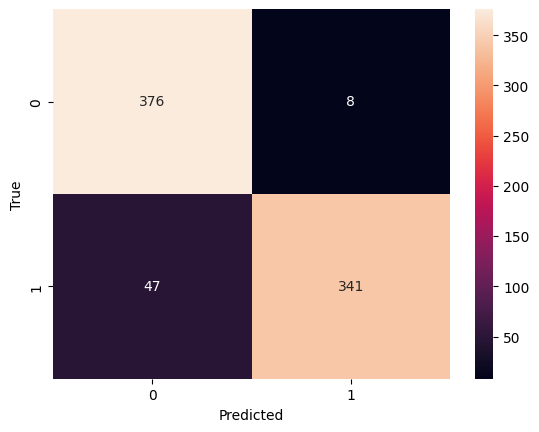

Elapsed Time: 26.23 seconds


In [ ]:
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


start_time = time() #kodun çalışma süresinin hesabı için başlangıç zamanı


#Datayı alma
class MyDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data.iloc[index, :-1].values.astype('float32')
        y = self.data.iloc[index, -1].astype('long')
        return x, y


train_dataset = MyDataset('cure_the_princess_train.csv')
test_dataset = MyDataset('cure_the_princess_test.csv')
val_dataset = MyDataset('cure_the_princess_validation.csv')
 
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


# SEED Ayarı 
SEED = 190401016

# PyTorch rastgele sayı üreticisini ayarla
torch.manual_seed(SEED)
np.random.seed(SEED)


# Modelin tanımlanması
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(13, 100) # birinci hidden layer'da 100 nöron
        self.fc2 = nn.Linear(100, 50) # ikinci hidden layer'da 50 nöron
        self.fc3 = nn.Linear(50, 2)   # output layer'da 2 nöron
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Modelin oluşturulması
model = MLP()

# Loss fonksiyonu
criterion = nn.CrossEntropyLoss()

# Optimizasyon algoritması
optimizer = optim.SGD(model.parameters(), lr=0.01) # Learning rate


epoch = 50
training_loss = 0
training_count = 0

list_valloss, list_trainloss, list_val_acc = [],[],[]
list_f1, list_precision, list_recall = [], [], []

best_val_loss = None
patience = 5
patience_counter = 0
# Modelin eğitilmesi
for epoch in range(epoch):

    for i, data in enumerate(train_loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs,labels)
        
        # L2 Regularization
        #Replaces pow(2.0) with abs() for L1 regularization
        l2_lambda = 0.001
        l2_norm = sum(p.abs().sum()
                    for p in model.parameters())

        loss = loss + l2_lambda * l2_norm


        optimizer.zero_grad()
        # outputs = model(inputs)
        #loss = criterion(outputs, labels)
        loss.backward(retain_graph=True)
        optimizer.step()
        training_count += 1
        training_loss += loss.item()
    
    # Modelin validate edilmesi
    
    val_loss = 0
    val_counter = 0
    val_predictions = []
    val_true_labels = []

    # ... devamı

    with torch.no_grad():
        model.eval()
        for i, data in enumerate(val_loader):
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_predictions.extend(predicted.tolist())
            val_true_labels.extend(labels.tolist())
            val_counter += len(labels)
        
        val_loss /= val_counter
        list_valloss.append(val_loss)
        
        # Accuracy, Precision, Recall ve F1 score hesaplanması
        val_accuracy = sum(np.array(val_predictions) == np.array(val_true_labels)) / val_counter
        val_precision = precision_score(val_true_labels, val_predictions)
        val_recall = recall_score(val_true_labels, val_predictions)
        val_f1 = f1_score(val_true_labels, val_predictions)
        
        list_val_acc.append(val_accuracy)
        list_precision.append(val_precision)
        list_recall.append(val_recall)
        list_f1.append(val_f1)

        print(f"Epoch {epoch+1}, Training Loss: {training_loss/training_count:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation F1-Score: {val_f1:.4f}")

        # Early stopping için patience kontrolü
        if best_val_loss is None:
            best_val_loss = val_loss
        elif val_loss > best_val_loss:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping!")
                break
        else:
            best_val_loss = val_loss
            patience_counter = 0

    model.train()


# Test veri seti üzerinde modelin performansının değerlendirilmesi
test_loss = 0
test_counter = 0
test_predictions = []
test_true_labels = []

with torch.no_grad():
    model.eval()
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = outputs.max(1)
        test_predictions.extend(predicted.tolist())
        test_true_labels.extend(labels.tolist())
        test_counter += len(labels)
        
test_loss /= test_counter
test_accuracy = sum(np.array(test_predictions) == np.array(test_true_labels)) / test_counter
test_precision = precision_score(test_true_labels, test_predictions)
test_recall = recall_score(test_true_labels, test_predictions)
test_f1 = f1_score(test_true_labels, test_predictions)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1-Score: {test_f1:.4f}")

# Confusion Matrix
confusion = pd.crosstab(pd.Series(test_true_labels, name='True'), pd.Series(test_predictions, name='Predicted'))
sns.heatmap(confusion, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Çalışma süresi
end_time = time()
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")



In [ ]:
# Regülarizasyondan önceki hali
#TestLoss: 0.0249, TestAccuracy: 0.9262, TestPrecision: 0.9825, TestRecall: 0.8686,Test F1-Score: 0.9220

# L2 Regülarizasyon sonrası
#Test Loss:0.0248, TestAccuracy: 0.9249, TestPrecision: 0.9714, TestRecall: 0.8763,Test F1-Score: 0.9214

# L1 Regülarizasyon sonrası
#TestLoss: 0.0251, TestAccuracy: 0.9288, TestPrecision: 0.9771, TestRecall: 0.8789,Test F1-Score: 0.9254

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6d4450f2-4874-44ad-970f-df290889114f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>